# Vending Machine simulator

an effort to make a Monte-Carlo simulator for VM that will help to understand effect of different policies about product selection and refil strategy.

In [2]:
import pandas as pd
import numpy as np
import random
import seaborn as sns
from matplotlib import pyplot as plt

from vmSim import *

# %matplotlib inline
%matplotlib widget
%load_ext autoreload
%autoreload 2


## Future considerations
- [ ] how to punish absense of variaty? 
    - e.g. introduce no_sale parameter that is some percentage for each category of products that is not present in VM that may hit no sale per customer
    - or do customer pick disregarding availability, and if not available then have some % that customer will do another pick
- [ ] cost of trip to refil, base cost of the crew
- [ ] map of locations (graph) with trasport costs b/w them for cost of trip estimate
- [ ] high level strategies: e.g. if one location is due for refill, then refill second in the same trip
- [ ] break downs?

# Some kind of introduction

In [23]:
# is a table with name and confidence interval of popularity
# popularity is just a number, it will later be normalized among all products, so relative is significant, not absolute
# log normal distribution is used to sample

products = {
    'coke': (50, 70),
    'beer': (10, 30),
    'water': (30, 50)
}

{'coke': 0.4623609582641996, 'beer': 0.1679887916561164, 'water': 0.36965025007968405}
[0.4623609582641996]


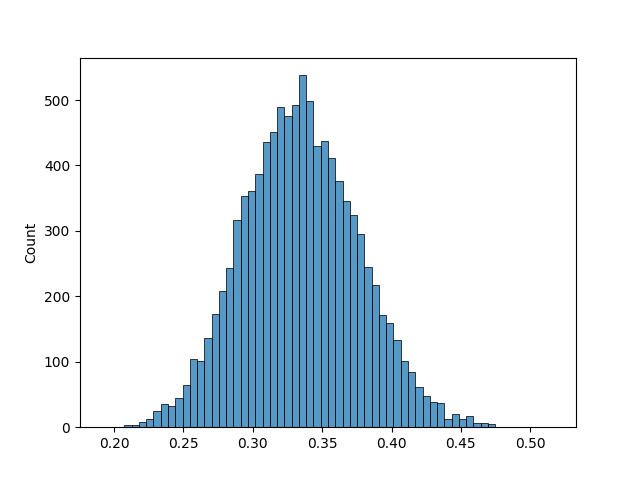

In [24]:
# example of Customer class
# it generates a random customer with preferences based on products popularity
c = Customer(products)
print(c.preferences)
print(c['coke'])

preferences = []
for _ in range(10_000):
    c = Customer(products)
    preferences.append(*c['water'])
    
plt.figure()
sns.histplot(data=np.array(preferences))
plt.show()

In [25]:
local_time = SimulationTime() # basically a counter to keep things sync

In [26]:
# primary attribute of the location is it's traffic that may be random and given by confidence interval
l = Location('Sakh', traffic_CI=(15, 30))
l.visits_today  # generates within confidence interval provided from lognormal distribution

15

In [27]:
columns = {  # name of product, count
    'coke': 20,
    'beer': 10,
}

# currently it's a dict, no definition of columns, but total ammount

In [70]:
# example of VendingMachine class
vm = VendingMachine(name='vm', columns=columns, location=l, time=local_time)
choices = vm.available_products
picked_product = c.pick(choices)
vm.dispense_product(picked_product)
vm.history

defaultdict(<function vmSim.VendingMachine.__init__.<locals>.<lambda>()>,
            {0: ['beer']})

# Simulation main functions

In [138]:
c.__dict__

{'preferences': {'coke': 0.5435832694034757,
  'beer': 0.14167302703332166,
  'water': 0.31474370356320275},
 'willingness_to_retry': 0.224698375710275}

In [44]:
def plot_stat(simulation, stat_name):
    plt.figure(figsize=(12, 5))
    plt.grid()
    sns.lineplot(data=simulation.__dict__[stat_name])
    plt.title(f'{stat_name.replace("_", " ").capitalize()} for "{simulation.name}" simulation')
    plt.show()

## Refill strategy

In [8]:
# there is base strategy to write and read history if it may be usefull later

class TopupExistingOnMinLevel(BaseStrategy):
    def __init__(self, name, min_level: int, topup: dict):
        self.name = name
        self.min_level = min_level
        self.topup = topup
    
    def make_refil_decision(self, vending_machine: VendingMachine) -> Union[bool, dict]:
        """
        takes state of provided vending machine and makes decision to refill or not
        if refill, returns product-ammount dict
        if not, returns False
        """
        self.vm = vending_machine
        decision = {}
        for name, ammount in self.vm.columns.items():
            decision[name] = self.topup[name] if ammount < self.min_level else 0
        if sum(decision.values()) == 0: decision = False
        self.write_decision(decision)
        return decision

In [9]:
class FillUpExistingToMaxOnMinLevel(BaseStrategy):
    def __init__(self, name, min_level: int, max_levels: dict):
        self.name = name
        self.min_level = min_level
        self.max_levels = max_levels
    
    def make_refil_decision(self, vending_machine: VendingMachine) -> Union[bool, dict]:
        """
        takes state of provided vending machine and makes decision to refill or not
        if refill, returns product-ammount dict
        if not, returns False
        """
        self.vm = vending_machine
        decision = {}
        for name, ammount in self.vm.columns.items():
            decision[name] = self.max_levels[name] - ammount if ammount < self.min_level else 0
        if sum(decision.values()) == 0: decision = False
        self.write_decision(decision)
        return decision

# Simulation

## Set up

In [10]:
local_time = SimulationTime()

low_traffic_loc = Location('boring place', traffic_CI=(3, 10))
high_traffic_loc = Location('railroad', traffic_CI=(20, 40))

# -- Products --

PRODUCTS = {
    'papa_beer': (30, 50),
    'mama_beer': (10, 20),
    'baby_beer': (1, 5),
    'water'    : (15, 25),
}

PRODUCTS_COSTS = {
    'papa_beer': 250,
    'mama_beer': 300,
    'baby_beer': 200,
    'water'    : 100,  
}

PRODUCTS_MARGIN = {
    'papa_beer': 70,
    'mama_beer': 100,
    'baby_beer': 150,
    'water'    : 50,  
}


# -- VMs --
vm1 = VendingMachine(name='vm1', location=low_traffic_loc, time=local_time, columns={
    'papa_beer': 40,
    'water'    : 40,
})

vm2 = VendingMachine(name='vm2', location=high_traffic_loc, time=local_time, columns={
    'papa_beer': 40,
    'mama_beer': 20,
    'baby_beer': 10,
    'water'    : 40,
})


VMs = [vm1, vm2]

# -- Strategies -- 
s_topup_low_at_5 = TopupExistingOnMinLevel('top_up_if_less_5', min_level=5, topup={
    'papa_beer': 15,
    'mama_beer': 10,
    'baby_beer': 5,
    'water'    : 15,      
})
s_topup_high_at_10 = TopupExistingOnMinLevel('top_up_if_less_10', min_level=10, topup={
    'papa_beer': 25,
    'mama_beer': 20,
    'baby_beer': 10,
    'water'    : 25,      
})
s_to_max_on_10 = FillUpExistingToMaxOnMinLevel('at 10 to max', min_level=10, max_levels= {
    'papa_beer': 100,
    'mama_beer': 100,
    'baby_beer': 50,
    'water'    : 100,      
})

STGs = {
    vm1: s_to_max_on_10,
    vm2: s_to_max_on_10,
}

## Running cycle

In [28]:
sim = Simulation('test run', 
                 products=PRODUCTS, 
                 product_costs=PRODUCTS_COSTS,
                 product_margins=PRODUCTS_MARGIN,
                 VMs=VMs,
                 STGs=STGs,
                 cycles=100,
                 local_time=local_time)

sim.run()

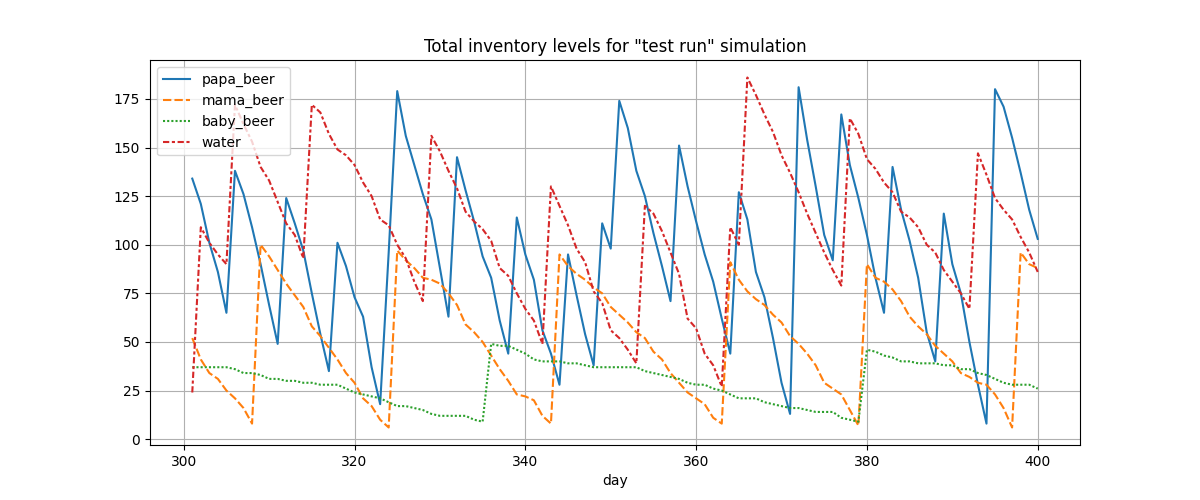

In [46]:
plot_stat(sim, 'total_inventory_levels')

Average inventory cost per day: 55,940.0 (sigma 13,351.0)


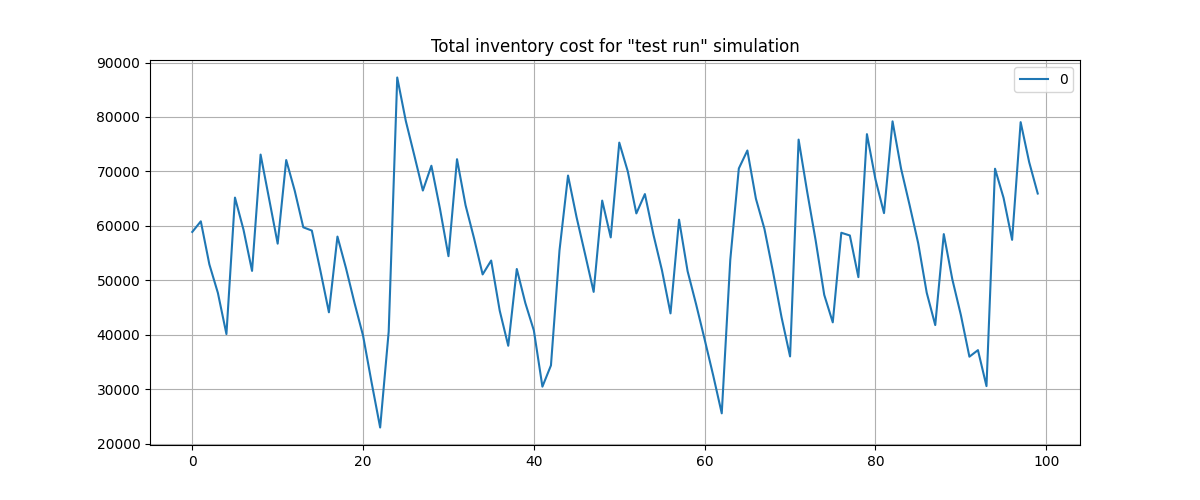

In [47]:
print(f'Average inventory cost per day: {np.mean(sim.total_inventory_cost):,.1f} (sigma {np.std(sim.total_inventory_cost):,.1f})')
plot_stat(sim, 'total_inventory_cost')

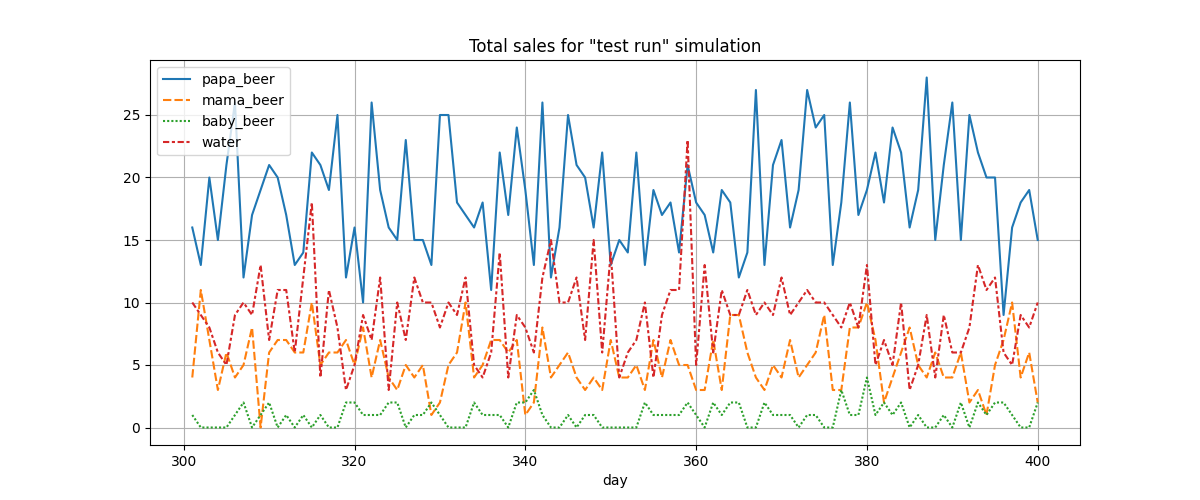

In [48]:
plot_stat(sim, 'total_sales')

Total sold outs for simulations: 28


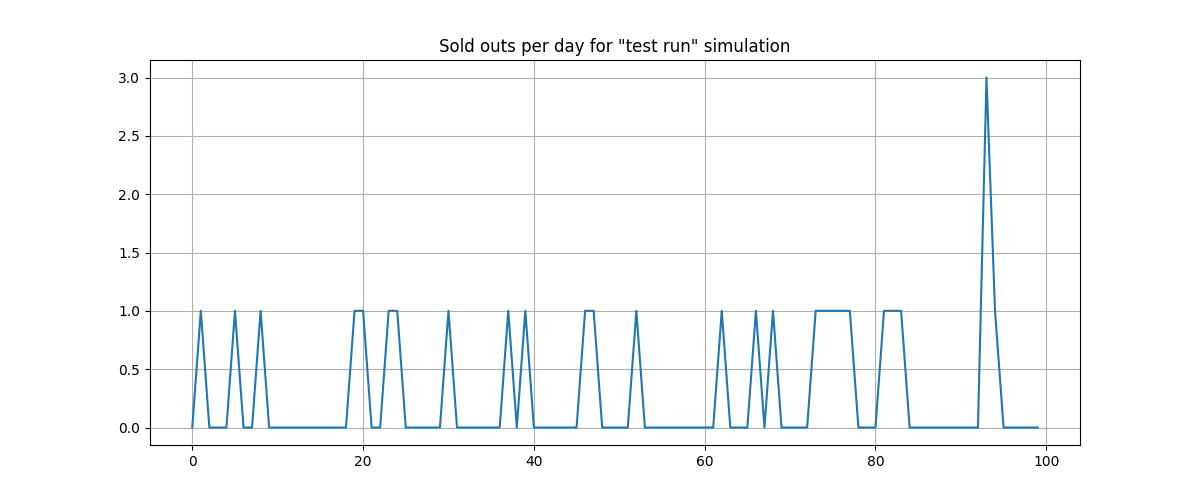

In [49]:
print(f'Total sold outs for simulations: {sum(sim.sold_outs_per_day)}')
plot_stat(sim, 'sold_outs_per_day')

Average profit per day: 2405.5 (sigma 416.2)


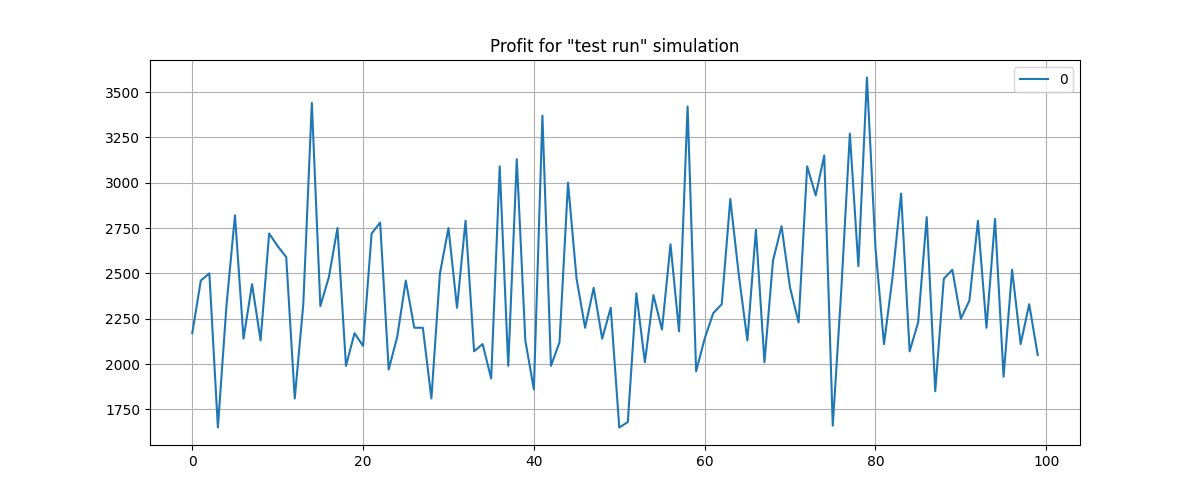

In [50]:
print(f'Average profit per day: {np.mean(sim.profit):.1f} (sigma {np.std(sim.profit):.1f})')
plot_stat(sim, 'profit')

Total top ups for simulations: 35


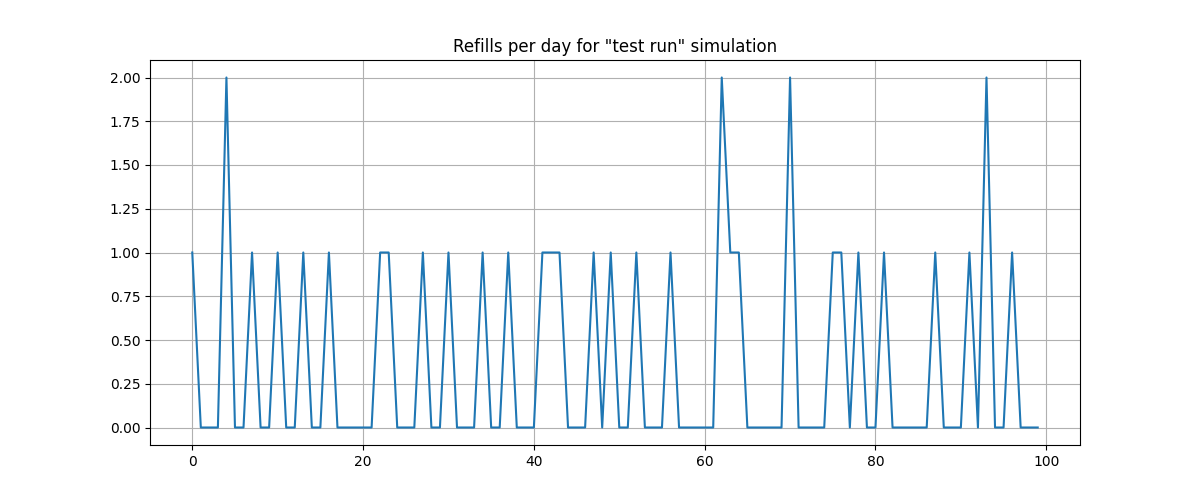

In [51]:
print(f'Total top ups for simulations: {sum(sim.refills_per_day)}')
plot_stat(sim, 'refills_per_day')

## Sort of economic model

In [134]:
interest_rate = 0.03
trip_cost = 500

In [135]:
expenses = sum(refills_per_day) * trip_cost + np.mean(total_inventory_cost)/365 * len(total_inventory_cost) * interest_rate
profits = sum(profit)[0]
revenue = profits - expenses
print(f"{revenue:,.1f} = {profits:,.1f} - {expenses:,.1f}")

22,390,674.1 = 24,108,840.0 - 1,718,165.9


strategies                revenue        profit         expenses

two low top ups:          16,881,656.2 = 23,223,010.0 - 6,341,353.8

two refills to max:       19,249,847.6 = 23,802,130.0 - 4,552,282.4

one low, one high top up: 18,481,499.1 = 24,001,140.0 - 5,519,640.9